In [1]:
#TweePy: Twitter API Python wrapper
#TextBlob: NLP library
#WordCloud: visualizing word frequency

In [2]:
import tweepy
import json
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as plticker
from collections import Counter
from scipy.stats import kurtosis

In [3]:
keys = pd.read_csv('twitterKeys.csv')
consumer_key = keys['keys'][0]
consumer_secret = keys['keys'][1]
access_token = keys['keys'][2]
access_secret = keys['keys'][3]

In [4]:
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret) 
authenticate.set_access_token(access_token, access_secret) 
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [5]:
def getUserPosts(user, number):
    timeline = api.user_timeline(screen_name = user, count = number, lang = "en", tweet_mode = "extended")
    arr = []
    j=1
    for i in timeline[:number]:
        arr.append(i.full_text)
        j += 1
    return arr
def getHashtagPosts(hashtag, num, date = None):
    timeline = list(api.search(hashtag, count = num, lang = 'en', tweet_mode = "extended"))
    arr = []
    j=1
    for i in timeline[:-1]:
        arr.append(i.full_text)
        j += 1
    return arr
def clean(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) 
    text = re.sub('RT[\s]+', '', text) 
    text = re.sub('https?:\/\/\S+', '', text)
 
    return text

In [6]:
def getSubjectivity(df, col = 'Tweets'):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr

def getPolarity(df, col = 'Tweets'):
    arr = []
    for i in df[col]:
        arr.append(TextBlob(i).sentiment.polarity)
    return arr


In [7]:
def analyze(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [8]:
def getSentiment(target, num, date = None):
    if target[0] == '#':
        arr = getHashtagPosts(target, num, date)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    else:
        arr = getUserPosts(target, num)
        frame = pd.DataFrame(arr, columns = ['Tweets'])
        cleaned = frame['Tweets'].apply(clean)
        cleaned  = cleaned.to_frame()
        cleaned['Subjectivity'] = getSubjectivity(cleaned, 'Tweets')
        cleaned['Polarity'] = getPolarity(cleaned, 'Tweets')
        cleaned['Outcome'] = cleaned['Polarity'].apply(analyze)
    return cleaned

In [9]:
def sortdf(dataframe, sorter = 'Polarity', order = False):
    return df.sort_values(by=[sorter], ascending = order )

In [10]:
def makeWordPlot(df, col = 'Tweets'):
    words = ' '.join([t for t in df[col]])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(words)
    plt.imshow(wordCloud, interpolation = "bilinear")
    plt.axis('off')
    plt.show()

In [11]:
def mostCommon(frame, col = 'Tweets', start = 0, end = -1):
    arr = frame[col]
    words = ' '.join([t for t in frame[col]])
    most_common = Counter(words.split()).most_common()
    return most_common[start:end]

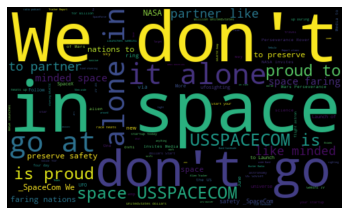

,Tweets,Subjectivity,Polarity,Outcome
0,It shouldn't be this hard to lower police leth...,-0.145833,-0.145833,Negative
1,: Cities develop around points of interest and...,0.325000,0.325000,Positive
2,: New posters are now available! #spaceart #s...,0.318182,0.318182,Positive
3,Kitting is a proven effective way to achieve a...,0.250000,0.250000,Positive
4,1: Legends speak of them.\nExtraordinary struc...,0.333333,0.333333,Positive
...,...,...,...,...
94,": On June 3 1965, #EdWhite was the first Ameri...",0.083333,0.083333,Positive
95,UFO sighting: Google Maps anomaly leaves alien...,-0.250000,-0.250000,Negative
96,The #InternationalSpaceStation is passing over...,0.357143,0.357143,Positive
97,NASA SpaceX launch: Alien hunters claim to spo...,-0.250000,-0.250000,Negative


In [12]:
df = getSentiment(('#space' or '#spacex' or '#nasa'), 1000)
makeWordPlot(df, 'Tweets')
df

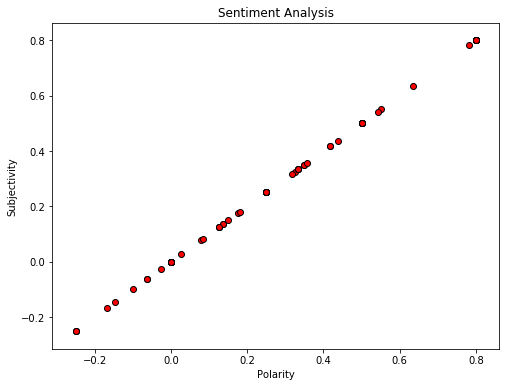

Covariance matrix for polarity and subjectivity:  
 [[0.11899628 0.11899628]
 [0.11899628 0.11899628]]
Pearson's correlation coefficient (for a linear plot) derived from the covariance matrix:  
 1.0


In [13]:
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
    plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='red', edgecolor = 'k') 
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()
cov = np.cov(np.array(df['Polarity']), np.array([df['Subjectivity']]))
print("Covariance matrix for polarity and subjectivity: ", '\n', np.cov(np.array(df['Polarity']), np.array([df['Subjectivity']])))
print("Pearson's correlation coefficient (for a linear plot) derived from the covariance matrix: ", '\n', np.corrcoef(df['Polarity'], df['Subjectivity'])[0,1])

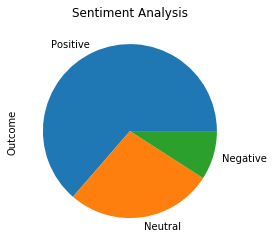

In [14]:
plt.title('Sentiment Analysis')
df['Outcome'].value_counts().plot(kind = 'pie')
plt.show()

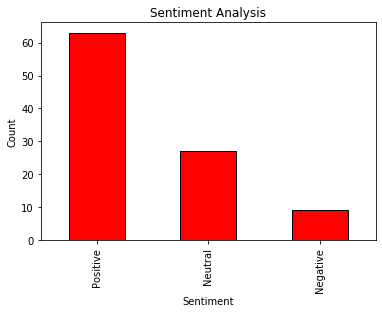

In [15]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
df['Outcome'].value_counts().plot(kind = 'bar', color = 'r', edgecolor = 'k')
plt.show()

Kurtosis:  -1.3802720210595967


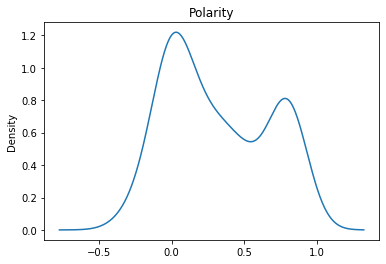

In [16]:
pol = df['Polarity'].plot(kind  = 'kde')
plt.title('Polarity')
print("Kurtosis: ", kurtosis(np.array(df['Polarity']), fisher = True, bias = False))

Kurtosis:  -1.3802720210595967


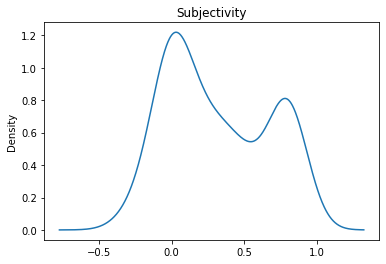

In [17]:
sub = df['Subjectivity'].plot(kind  = 'kde')
plt.title('Subjectivity')
print("Kurtosis: ", kurtosis(np.array(df['Subjectivity']), fisher = True, bias = False))

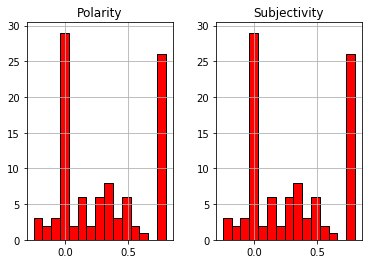

In [18]:
hist = df.hist(bins = 15, color = 'r', edgecolor = 'k')